### 1. 引入依赖

In [1]:
# 类型 限制
from typing import Annotated, Literal, TypedDict
# 人类消息
from langchain_core.messages import HumanMessage
# 加载大模型
from models import get_chat
# 当做装饰器使用，把一个普通的函数变成一个agent可以调用的工具
from langchain_core.tools import tool
# 消息持久化
from langgraph.checkpoint.memory import MemorySaver
# 引入预定义的一些类或工具
from langgraph.graph import END, START, StateGraph, MessagesState
# 引入一个预编译的工具节点
from langgraph.prebuilt import ToolNode
# 引入一个 datetime
from datetime import datetime

### 2. 定义外部工具

In [2]:
# 定义一个工具
# @tool 写不写都可以
@tool
def get_current_datetime() -> str:
    """
        查询当前的日期和时间
    """ 
    now = datetime.now()
    formatted_date = now.strftime("%Y-%m-%d %H:%M:%S")
    return formatted_date

@tool
def get_apple_price(model: str) -> int:
    """
        查询苹果手机的价格！
        入参：model 是苹果手机的型号，目前，只有如下3个型号 '4s'、'5s'、'6s'，其它型号暂不支持
    """ 
    if model == "4s":
        return 4000
    elif model == "5s":
        return 5000
    elif model == "6s":
        return 6000
    else:
        raise ValueError("model 是苹果手机的型号，目前，只有如下3个型号 '4s'、'5s'、'6s'，其它型号暂不支持")

In [3]:
call_datetime = ToolNode(tools=[get_current_datetime], name="datetime")
call_apple_price = ToolNode(tools=[get_apple_price], name="apple_price")

In [4]:
# 连接大模型
model = get_chat()
# 绑定工具
model_with_tools = model.bind_tools(tools=[get_apple_price, get_current_datetime])

In [5]:
# result = model_with_tools.invoke(input=[HumanMessage(content="几点了？")])

In [6]:
# result

In [7]:
# result.tool_calls

In [8]:
# 定义一个条件边
def should_continue(state: MessagesState) -> Literal["datetime", "apple_price", END]:
    # 获取当前的消息
    messages = state['messages']
    # 取出最后一条消息
    last_message = messages[-1]
    # 如果大模型发出工具调用请求，我们就转向 工具节点
    # print(last_message)
    if not last_message.tool_calls:
        return END
    elif last_message.tool_calls[0]["name"] == "get_current_datetime":
        return "datetime"
    else: 
        return "apple_price"

In [9]:
# Define the function that calls the model
def call_model(state: MessagesState):
    # 取出消息列表（所有的历史对话）
    messages = state['messages']
    # 调用大模型
    response = model_with_tools.invoke(messages)
    # 只需要通过列表形式返回当前这一步的消息即可
    # 系统会自动把当前这一步的消息追加到 系统状态中
    return {"messages": [response]}

In [10]:
# 定义一个新的图
workflow = StateGraph(MessagesState)
# 添加一个大模型节点
workflow.add_node(node="model", action=call_model)
# 添加一个查询日期和时间的节点
workflow.add_node(node="datetime", action=call_datetime)
# 添加一个查询苹果手机价格节点
workflow.add_node(node="apple_price", action=call_apple_price)
# 添加一条边
workflow.add_edge(start_key=START, end_key="model")
# 添加一个条件边
workflow.add_conditional_edges(source="model", path=should_continue)
# 工具掉完，都转向大模型
workflow.add_edge(start_key="datetime", end_key='model')
workflow.add_edge(start_key="apple_price", end_key='model')

In [11]:
# 消息持久化
checkpointer = MemorySaver()
# 编译整个图
agent = workflow.compile(checkpointer=checkpointer)

### 把图可视化

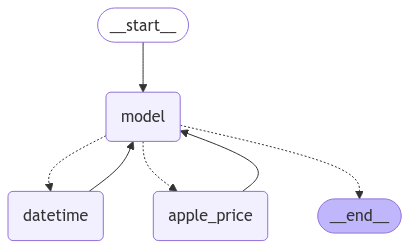

In [12]:
from IPython.display import Image, display

try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [13]:
# 调用 Agent
final_state = agent.invoke(input={"messages": [HumanMessage(content="新中国成立多少年，我就买多少部5s，请问我该准备多少钱？")]},
                           config={"configurable": {"thread_id": 42}})
# 只打印最后一条消息
final_state["messages"][-1].content

'现在是2025年1月5日，而新中国是在1949年成立的。从1949年到2025年已经过去了 \\(2025 - 1949 = 76\\) 年。\n\n根据您的要求，您想购买76部iPhone 5s。每部iPhone 5s的价格是5000元，那么总共需要准备的钱是 \\(76 \\times 5000 = 380,000\\) 元。\n\n所以您应该准备380,000元。'

In [14]:
# 打印所有消息
for msg in final_state["messages"]:
    msg.pretty_print()

================================ Human Message =================================

新中国成立多少年，我就买多少部5s，请问我该准备多少钱？
================================== Ai Message ==================================

首先，我们需要知道新中国成立的年份以及现在的时间。先查询一下现在的日期和时间。
Tool Calls:
  get_current_datetime (call_3eb4c520ee874708b22afc)
 Call ID: call_3eb4c520ee874708b22afc
  Args:
================================= Tool Message =================================
Name: get_current_datetime

2025-01-05 11:06:14
================================== Ai Message ==================================
Tool Calls:
  get_apple_price (call_78c96e4aaf914629b42598)
 Call ID: call_78c96e4aaf914629b42598
  Args:
    model: 5s
================================= Tool Message =================================
Name: get_apple_price

5000
================================== Ai Message ==================================

现在是2025年1月5日，而新中国是在1949年成立的。从1949年到2025年已经过去了 \(2025 - 1949 = 76\) 年。

根据您的要求，您想购买76部iPhone 5s。每部iPhone 5s的价格是5000元，那么总共需要准备的钱是 \(76 \t